In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import numpy as np
from math import sqrt
from qutip import *
from qutip import sigmax, sigmay, sigmaz, basis, qeye, tensor, Qobj, fock_dm, fidelity
from qutip_qip.circuit import QubitCircuit, Gate
from qutip.qip.operations.gates import rx
from qutip_qip.device import ModelProcessor, Model, CavityQEDModel
from qutip_qip.compiler import GateCompiler, Instruction, CavityQEDCompiler
from qutip.qip.device import DispersiveCavityQED
from qutip import Options
from qutip_qip.noise import Noise, ZZCrossTalk
from qutip.qip.noise import RelaxationNoise

In [3]:
# Test CavityQED Model by using DispersiveCavityQED on only 1 qubit coupled to cavity first
# confirm results with Schuster Thesis expectation

# params 
num_qubits = 1
num_c_levels = 10
num_gates = 1
init_fid = 1 # initial fidelity
g1 = 10
delta1 = 10
eps1 = 1
wq1 = np.sqrt(delta1**2 + eps1**2) # qubit resonance frequency
w0=10 # cavity resonance frequency
detuning = abs(w0-wq1) # qubit cavity detuning


# make the model + circuit
qc = QubitCircuit(num_gates, num_cbits=num_qubits)

proc = DispersiveCavityQED(1, w0=w0, g=[g1], eps=[eps1], delta=[delta1])

qc.add_gate("RX", targets=0, arg_value=np.pi/2) # target in [q1, q2], apply pi/2 pulse

# make gates to load into the processor
tlist, coeff = proc.load_circuit(qc)
sx0_pulse = proc.find_pulse("sx0")
print(sx0_pulse.coeff, sx0_pulse.tlist) # rectangular pulse

[6.28318531] [0.    0.125]


In [5]:
# run the simulation

# pauli spin operator for qubits
sm = tensor(qeye(num_c_levels), destroy(2))

# destruction operator for cavity
a = tensor(destroy(num_c_levels), qeye(2))

# measure the occupation of the qubit
e_ops = [sm.dag()*sm ]


init_state = tensor(basis(10,0), basis(2,0))
result = proc.run_state(init_state, options=Options(nsteps=10000))
test_result = proc.run_state(init_state, e_ops=e_ops)

Output Quantum object: dims = [[10, 2], [1, 1]], shape = (20, 1), type = ket
Qobj data =
[[0.70719623+0.j        ]
 [0.        -0.70701733j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]]
number of photons expected in qubit 1 from schuster: 100.2493781056051
number of photons expected in qubit 1 from simulation: 0.4998734985469967


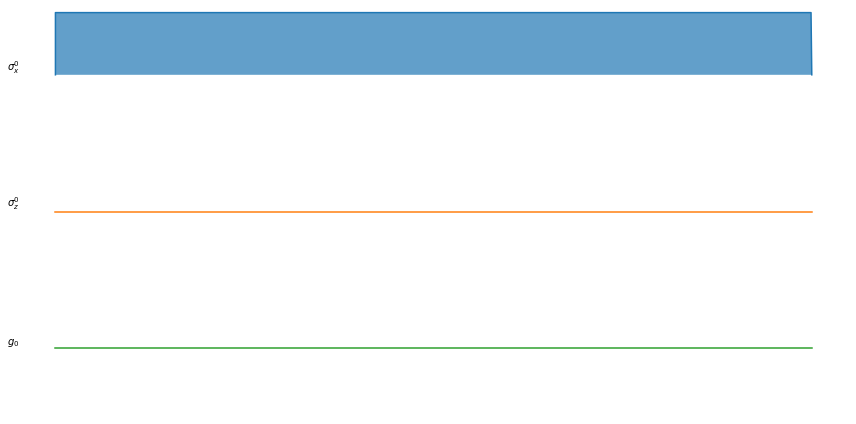

In [6]:
# get the info from the simulation
print(f"Output {result.states[-1]}")
print(f"number of photons expected in qubit 1 from schuster: {g1*0.5/detuning}")
print(f"number of photons expected in qubit 1 from simulation: {test_result.expect[0][-1]}")

# if the qubits are in the dispersive regime, should expect gsqrt(n)/delta occupation
proc.plot_pulses()
plt.show()